In [1]:
import numpy
import commonblock

tracks = commonblock.NumpyCommonBlock(
    trackermu_qoverp     = numpy.zeros(1000, dtype=numpy.double),
    trackermu_qoverp_err = numpy.zeros(1000, dtype=numpy.double),
    trackermu_phi        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_eta        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_dxy        = numpy.zeros(1000, dtype=numpy.double),
    trackermu_dz         = numpy.zeros(1000, dtype=numpy.double),
    globalmu_qoverp      = numpy.zeros(1000, dtype=numpy.double),
    globalmu_qoverp_err  = numpy.zeros(1000, dtype=numpy.double))

hits = commonblock.NumpyCommonBlock(
    detid      = numpy.zeros(5000, dtype=numpy.uint64),
    localx     = numpy.zeros(5000, dtype=numpy.double),
    localy     = numpy.zeros(5000, dtype=numpy.double),
    localx_err = numpy.zeros(5000, dtype=numpy.double),
    localy_err = numpy.zeros(5000, dtype=numpy.double))

In [2]:
import FWCore.ParameterSet.Config as cms

process = cms.Process("Demo")

process.load("FWCore.MessageService.MessageLogger_cfi")

process.maxEvents = cms.untracked.PSet(input = cms.untracked.int32(1000))

process.source = cms.Source(
    "PoolSource", fileNames = cms.untracked.vstring("file:MuAlZMuMu-2016H-002590494DA0.root"))

process.demo = cms.EDAnalyzer(
    "DemoAnalyzer",
    tracks = cms.uint64(tracks.pointer()),   # pass the arrays to C++ as a pointer
    hits   = cms.uint64(hits.pointer()))

process.p = cms.Path(process.demo)

In [3]:
import threading
import libFWCorePythonFramework
import libFWCorePythonParameterSet

class CMSSWThread(threading.Thread):
    def __init__(self, process):
        super(CMSSWThread, self).__init__()
        self.process = process

    def run(self):
        processDesc = libFWCorePythonParameterSet.ProcessDesc()
        self.process.fillProcessDesc(processDesc.pset())

        cppProcessor = libFWCorePythonFramework.PythonEventProcessor(processDesc)
        cppProcessor.run()

In [4]:
cmsswThread = CMSSWThread(process)
cmsswThread.start()

tracks.wait(1)   # CMSSW notifies that it has filled the tracks array
tracks.pandas()

,globalmu_qoverp,globalmu_qoverp_err,trackermu_dxy,trackermu_dz,trackermu_eta,trackermu_phi,trackermu_qoverp,trackermu_qoverp_err
0,-0.010567,0.000176,-0.068008,5.044248,1.345596,-2.698669,-0.010630,0.000154
1,0.006895,0.000151,0.054830,4.506279,1.833096,0.569517,0.006876,0.000148
2,0.019243,0.000203,0.049390,-1.901605,0.103585,0.658894,0.019275,0.000230
3,-0.023387,0.000218,-0.095338,-1.904487,-0.249766,-2.945127,-0.023375,0.000224
4,-0.004139,0.000135,0.116625,-8.595935,-1.881879,-0.706054,-0.004042,0.000107
5,0.015591,0.000239,-0.066035,-8.682809,-1.252449,-2.672938,0.015586,0.000239
6,0.037974,0.000364,0.032850,-0.111745,-0.257494,-1.806014,0.037933,0.000375
7,-0.009422,0.000226,0.009904,-0.572965,2.108640,0.986081,-0.009398,0.000228
8,0.018069,0.000190,0.119466,-1.273930,0.374561,-0.530472,0.018046,0.000195
9,-0.022957,0.000241,-0.111564,-1.262620,0.426754,2.919330,-0.022932,0.000246


In [5]:
hits.pandas()

,detid,localx,localx_err,localy,localy_err
0,604018352,-14.661780,0.000339,8.819818,0.141031
1,637612422,15.698437,1.642616,0.000000,200.085754
2,637579686,16.581907,2.337946,0.000000,317.243591
3,604021936,-15.579300,0.000682,-75.140610,0.308281
4,604026032,17.155981,0.000775,-1.725272,0.355754
5,637645258,-17.506124,2.727962,0.000000,304.015594
6,604030128,18.839199,0.000826,47.635704,0.334478
7,637612522,19.774876,3.734178,0.000000,480.071472
8,604017696,4.622838,0.000176,9.101110,0.141533
9,604021264,27.893734,0.000855,21.453674,0.048724


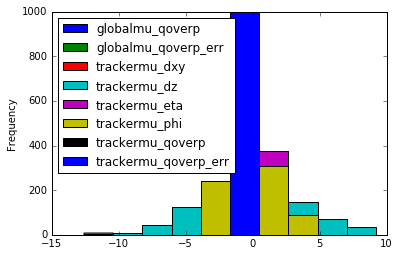

In [7]:
%matplotlib inline

tracks.pandas().plot.hist()